In [7]:
import numpy as np
import matplotlib.pyplot as plt


def create_scrna_heatmap(
    num_features=100,
    num_samples=50,
    zero_inflation_prob=0.2,
    figure_size=(10, 8),
    dpi=300,
    text_size=10,
    save_format="png",
    output_filename="scrna_heatmap",
):
    """
    Simulate scRNA-seq data (with zero inflation) and plot as a heatmap.

    Parameters
    ----------
    num_features : int
        Number of features (e.g., genes).
    num_samples : int
        Number of samples (e.g., cells).
    zero_inflation_prob : float
        Probability of artificially setting expression to zero (zero inflation).
    figure_size : tuple
        Size of the figure in inches, e.g. (width, height).
    dpi : int
        Resolution of the figure in dots per inch.
    text_size : int
        Font size for axis tick labels.
    save_format : str
        Format to save the figure in ('png', 'pdf', 'jpg', etc.).
    output_filename : str
        Base filename for saving the figure.

    Returns
    -------
    data : np.ndarray
        Simulated scRNA-seq matrix of shape (num_features, num_samples).
    """

    # 1. Simulate raw expression data using a Poisson distribution
    #    (You could replace this with another distribution, e.g. Negative Binomial)
    np.random.seed(42)  # For reproducibility; remove or change as needed
    lam = 5  # Poisson mean (arbitrary choice)
    data = np.random.poisson(lam, size=(num_features, num_samples))

    # 2. Introduce zero inflation
    #    Create a mask where some fraction (zero_inflation_prob) of entries are set to zero
    zero_mask = np.random.binomial(
        1, zero_inflation_prob, size=(num_features, num_samples)
    )
    data[zero_mask == 1] = 0

    # 3. Plot the heatmap
    plt.figure(figsize=figure_size, dpi=dpi)
    plt.imshow(data, aspect="auto", interpolation="nearest")
    plt.colorbar(label="Expression")

    # 4. Label the axes with sample and feature indices
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("Samples", fontsize=text_size)
    plt.ylabel("Features", fontsize=text_size)

    # Tight layout to accommodate rotated labels
    plt.tight_layout()

    # 5. Save the figure
    plt.savefig(f"{output_filename}.{save_format}", format=save_format, dpi=dpi)

    # Display the plot
    plt.show()

    return data

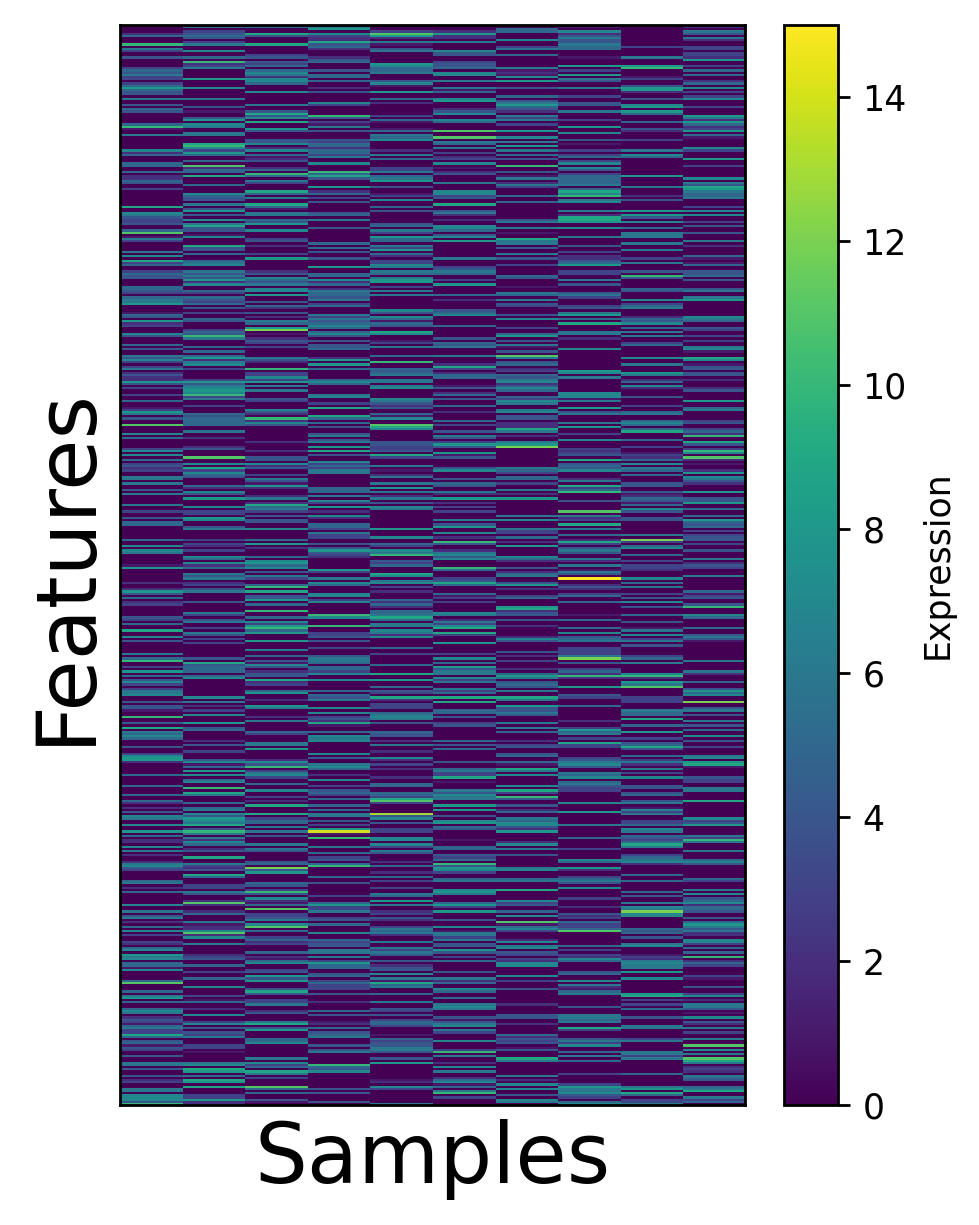

In [12]:
# Create a heatmap of a 50x20 matrix with 25% zero inflation
data_matrix = create_scrna_heatmap(
    num_features=500,
    num_samples=10,
    zero_inflation_prob=0.50,
    figure_size=(4, 5),
    dpi=250,
    text_size=24,
    save_format="svg",
    output_filename="my_scRNA_heatmap",
)

In [46]:
import logging
from typing import Optional

import anndata
from scipy.sparse import csr_matrix

# Obtain a pre-defined logger
logger = logging.getLogger(__name__)


def create_histogram_from_adata(
    adata: anndata.AnnData,
    expression_key: str = "X",
    bins: int = 50,
    svg_output: Optional[str] = None,
    label_fontsize: int = 14,
    tick_fontsize: int = 12,
) -> None:
    """
    Create a histogram of expression values from a given AnnData object.

    This function takes an AnnData object, extracts its expression values (either
    from `adata.X` or a specified layer), and creates a histogram of the flattened
    expression data. Note that you should perform any log transformations before
    calling this function if you want to visualize log-scaled data.

    Parameters
    ----------
    adata : anndata.AnnData
        The AnnData object containing transcriptomic data from a single sample or
        multiple samples. This data is presumably sourced from RNA-seq or single-cell
        experiments. Provide references to the original dataset where appropriate.
    expression_key : str, optional
        The key specifying which matrix to use for extracting expression values.
        - If set to "X", the data will be taken from `adata.X`.
        - Otherwise, it will be taken from `adata.layers[expression_key]`.
        Defaults to "X".
    bins : int, optional
        The number of bins to use for the histogram. Defaults to 50.
    svg_output : str, optional
        If provided, saves the resulting plot as an SVG file at the specified path.
        If `None`, the plot will simply be displayed without being saved.
        Defaults to None.

    Returns
    -------
    None
        The function generates a histogram plot and either displays it or saves it
        as an SVG file, depending on the `svg_output` argument.

    Notes
    -----
    1. Ensure that the expression data is log-transformed beforehand if you want a
       log-scaled histogram.
    2. Large datasets might require adjustments (e.g., `bins` or figure size) to
       improve readability.
    3. Provide references to the source of the data in your manuscript or figure
       caption as needed.
    """
    logger.info("Starting histogram creation from AnnData object.")

    # Extract expression data from adata
    if expression_key == "X":
        data = adata.X
        logger.debug("Using 'X' matrix from adata.")
    else:
        if expression_key not in adata.layers:
            logger.error(
                f"Expression key '{expression_key}' not found in adata.layers."
            )
            raise ValueError(
                f"Expression key '{expression_key}' not found in adata.layers."
            )
        data = adata.layers[expression_key]
        logger.debug(f"Using layer '{expression_key}' from adata.")

    if isinstance(data, csr_matrix):
        data = data.toarray()
    # Convert to 1D numpy array for histogram
    expression_values = data.flatten()
    logger.debug(f"Extracted {expression_values.size} total expression values.")

    # Create the histogram
    plt.figure(figsize=(8, 6))
    plt.hist(expression_values, bins=bins, color="skyblue", edgecolor="black")
    plt.xlabel("log2 expression", fontsize=label_fontsize)
    plt.ylabel(None, fontsize=label_fontsize)
    plt.xticks(fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)
    plt.tight_layout()
    plt.tight_layout()

    # Save or display
    if svg_output is not None:
        plt.savefig(svg_output, format="svg")
        logger.info(f"Histogram saved as SVG at: {svg_output}")
    else:
        plt.show()
        logger.info("Histogram displayed on screen.")

    logger.info("Histogram creation completed.")

In [50]:
import anndata
import scanpy as sc

adata = anndata.read("../data/RNA/raw/train/cellxgene_pseudo_bulk_3_5k.h5ad")

/Users/mengerj/repos/adata_hf_datasets/.venv/lib/python3.12/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [51]:
sc.pp.log1p(adata)
sc.pp.filter_genes(adata, min_cells=1000)

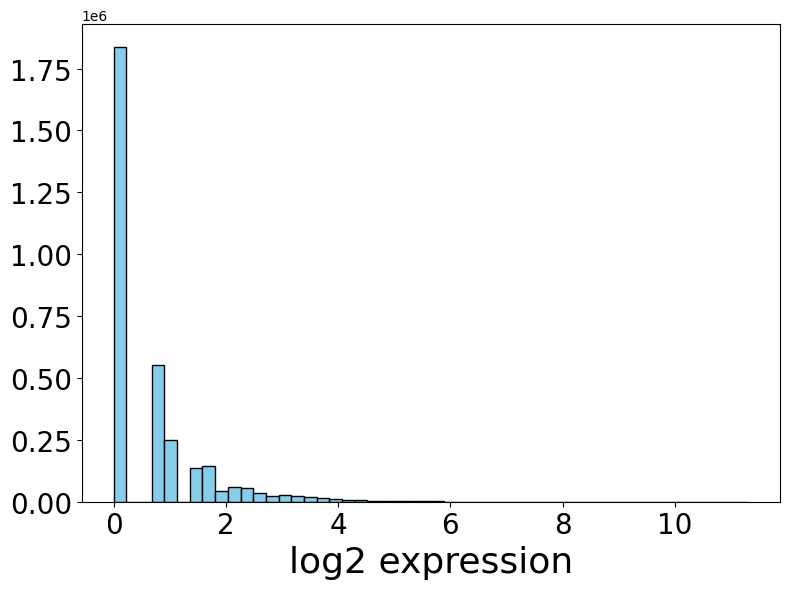

In [55]:
create_histogram_from_adata(
    adata,
    expression_key="X",
    bins=50,
    svg_output="histogram.svg",
    label_fontsize=26,
    tick_fontsize=20,
)